## 0. Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math
pylab.rcParams['figure.figsize'] = (8.25, 6)
from sklearn.metrics import roc_curve, auc

Importing and formatting the training data

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")

In [3]:
# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [0]]


# Make sure variable is right
list(tornado_outcome)

['DAMAGE_PROPERTY']

In [4]:
# The predictors
tornado_predictors = tor_df.iloc[:, 1:]


# Make sure the variables are right
list(tornado_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

In [5]:
# Make the outcomes into a numpy array
outcome_array = tornado_outcome.values

# Makes that numpy array into a torch Tensor
outcome_Tensor = torch.from_numpy(outcome_array)


# Make the predictors into a numpy array
predictors_array = tornado_predictors.values

# Make that numpy array into a torch Tensor
predictors_Tensor = torch.from_numpy(predictors_array)


# Convert those DoubleTensors to FloatTensors
# Changing outcomes from a DoubleTensor to a FloatTensor
outcome_Tensor = outcome_Tensor.float()

# Changing predictors too
predictors_Tensor = predictors_Tensor.float()

Now the cross-validation data

In [6]:
# Import cross-validation data
cv_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Get the outcomes
cv_outcome = cv_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
cv_outcome_Tensor = torch.from_numpy(cv_outcome.values).float()


# Make sure the variable is right
list(cv_outcome)

['DAMAGE_PROPERTY']

In [7]:
# Get the validation set predictors
cv_predictors = cv_df.iloc[:, 1:]

# Make the validation set predictors into a numpy array
cv_predictors_Tensor = torch.from_numpy(cv_predictors.values).float()


# Make sure the variables are right
list(cv_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

## 1. Remake the Best Neural Network

Define the model architecture

In [8]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 50)
        self.fc2 = torch.nn.Linear(50, 50)
        self.fc3 = torch.nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, p = 0.10, training = self.training)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.dropout(x, p = 0.10, training = self.training)
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

Define the loss function

In [9]:
loss_fn = torch.nn.MSELoss(size_average = False)

Defining a function to setup and train the models. It will also produce a loss versus iteration plot

In [10]:
def train_neural_net(model, train_outcomes, train_inputs,
                     cv_outcomes, cv_inputs):
    
    # This function will train the neural network and produce a loss versus iteration plot
    # model = the model architecture, a Net class
    # train_outcomes = the right answers, PyTorch Tensor
    # train_inputs = what we're using to get to the right answers, PyTorch Tensor
    # cv_outcomes = the right answers of the new data, PyTorch Tensor
    # cv_inputs = what we're using to get the new right answers, PyTorch Tensor
    # Returns a plot and a trained Net
    
    
    # Make the outcomes into a Torch Variable
    outcome_Variable = Variable(train_outcomes)
    
    # Make the cv outcomes into a Torch Variable
    cv_outcome_Variable = Variable(cv_outcomes,
                                   requires_grad = False)
    
    # Make the predictors into a Torch Variable
    predictors_Variable = Variable(train_inputs,
                                   requires_grad = False)
    
    # Make the cv predictors into a Torch Variable
    cv_predictors_Variable = Variable(cv_inputs,
                                      requires_grad = False)
    
    
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_cv_loss_value = []
    
    
    # Set the optimizer
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    
    # Train the neural network
    for t in range(20000):
        
        # Get the current mini-batch indices
        indices = torch.randperm(len(predictors_Tensor))[0:50]
        
        # Get the current mini-batches
        predictors_mini = predictors_Variable[indices]
        outcome_mini = outcome_Variable[indices]
        
        # Get the current predictions
        model.train()
        current_pred_mini = model(predictors_mini)
        model.eval()
        cv_pred = model(cv_predictors_Variable)
        model.train()
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data[0])
        
        current_cv_loss = loss_fn(cv_pred, cv_outcome_Variable)
        current_cv_loss_value.append(current_cv_loss.data[0])
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
    
    
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_cv = (np.asarray(current_cv_loss_value) / len(cv_predictors_Variable)).tolist()
    
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_cv, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

Train the first model.

The plot will display how well it optimized. The blue line is the mini batch values that the model was optimized on, while the red line is new (cross-validation) data.

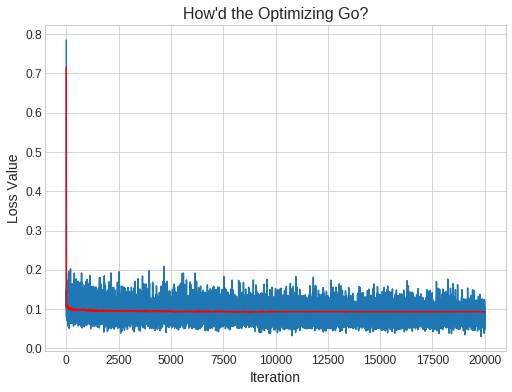

In [11]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

How'd the model perform on the data used to make it?

In [12]:
def plot_train_perf(train_predictors, train_obs, model, alpha_val, hor_line,
                    lower_bound, upper_bound, label1, label2, diag_line):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictions = model(Variable(train_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = train_predictions.tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = train_obs.numpy().tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, alpha = alpha_val, facecolor = 'k')
    axes = plt.gca()
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlim(lower_bound, upper_bound)
    plt.ylim(lower_bound, upper_bound)
    axes.set_xlabel(label1, size = 14)
    axes.set_ylabel(label2, size = 14)
    axes.set_title("Model Performance on Training Data", size = 16);
    
    if hor_line == True:
        
        plt.axhline(y = 0.5, color = 'r');
        
    if diag_line == True:
        
        plt.plot([lower_bound, upper_bound], [lower_bound, upper_bound]);

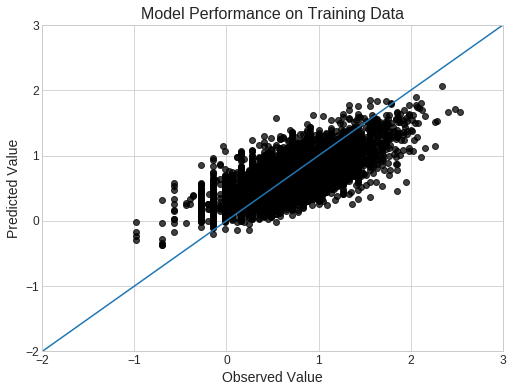

In [13]:
plot_train_perf(predictors_Tensor, outcome_Tensor, model, 0.75, False,
                -2, 3, 'Observed Value', 'Predicted Value', True)

### 1.1 Performance Metrics

We're really interested in how it does on new data, so let's get some metrics of its performance on the new data.

First: Mean squared error (MSE)

In [14]:
def compute_MSE(predictors, observed_outcomes):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Set the model in evaluation mode
    model.eval()
    
    # Get the validation set predictions
    cv_predictions = model(Variable(predictors, requires_grad = False))
    
    # Get the validation set outcomes
    cv_outcomes = Variable(observed_outcomes)
    
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(cv_predictions, cv_outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [15]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)

Second: MSE for observed values over 1 million dollars

In [16]:
def compute_MSE_over_1mil(predictors, observed_outcomes):
    
    # Computes the mean squared error on observed values of over 1 million dollars
    # predictors = the variables and values used in prediction, PyTorch Tensor
    # observed_outcomes = what the prediction would ideally yield, PyTorch Tensor
    # Returns a PyTorch Variable
    
    
    # Set the model in evaluation mode
    model.eval()
    
    # Getting the model-ready equivalent of 1 million
    one_million = (np.log(1e6 + 1) - 7.688844) / 5.407597
    
    # Combining predictions and observations into a DataFrame
    df = pd.DataFrame(model(Variable(predictors)).data.numpy())
    df.columns = ['predicted']
    df['observed'] = observed_outcomes.numpy()
    
    # Only keeping rows which contain observed values greater than 1 million dollars
    df = df.loc[df['observed'] >= one_million]
    
    # Making those columns model-ready
    predicted = Variable(torch.from_numpy(np.asarray(df['predicted'])))
    observed = Variable(torch.from_numpy(np.asarray(df['observed'])))
    
    # Get the MSE
    total_SE = loss_fn(predicted, observed)
    mean_SE = total_SE / len(df['observed'])
    return(mean_SE)

In [17]:
MSE_over_1mil = compute_MSE_over_1mil(cv_predictors_Tensor, cv_outcome_Tensor)

Third: R<sup>2</sup> (R-squared)

In [18]:
def compute_R_squared(predictors, observed_outcomes):
    
    # Computes R-squared of the model
    # predictors = the variables and values used in prediction, PyTorch Tensor
    # observed_outcomes = what the prediction would ideally yield, PyTorch Tensor
    # Returns a PyTorch Variable
    
    
    # Set the model in evaluation mode
    model.eval()
    
    # Get the mean of the observed outcomes
    observed_mean = (sum(observed_outcomes) / len(observed_outcomes)).numpy()[0]
    
    # Fill an ndarray with that
    valid_outcomes_mean = np.repeat(observed_mean, len(observed_outcomes))
    
    # Convert that to a Variable
    valid_outcomes_mean = Variable(torch.from_numpy(valid_outcomes_mean))
    
    
    # Compute total sum of squares
    TSS = loss_fn(valid_outcomes_mean, Variable(observed_outcomes))
    
    
    # Compute residual sum of squares
    RSS = loss_fn(model(Variable(predictors)), Variable(observed_outcomes))
    
    
    # Compute R-squared
    R_squared = 1 - (RSS / TSS)
    return(R_squared)

In [19]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)

### 1.2 Performance Visualization

In log-transformed space, plot predicted values versus observed values for new data

In [20]:
def plot_cross_valid_perf(cv_predictors, cv_obs):
    
    # Plots how well the model performs on new data
    # cv_pred = the values that the model predicts from, PyTorch Tensor
    # cv_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Set the model in evaluation mode
    model.eval()
    
    # Convert to a PyTorch Variable and get the predictions
    cv_predictions = model(Variable(cv_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    cv_predictions = cv_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    cv_predictions = (cv_predictions*5.407597 + 7.688844).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    cv_obs = (cv_obs.numpy()*5.407597 + 7.688844).tolist()
    
    
    # Plot it
    plt.scatter(cv_obs, cv_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")
    axes.set_title("Model Performance on Cross-Validation Data", size = 16)
    plt.text(0.5, 22, r"$R^2$ = %s"%(R_squared.data.numpy()[0]), size = 12)
    plt.text(0.5, 20, "MSE = %s"%(MSE.data.numpy()[0]), size = 12)
    plt.text(0.5, 18, "MSE over 1M = %s"%(MSE_over_1mil.data.numpy()[0]), size = 12)

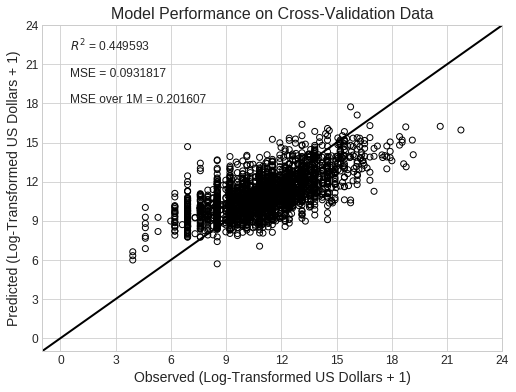

In [21]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

## 2. Remake the classifier

### 2.1 Set up

In [22]:
# Import the training data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")


# Get the outcomes
tornado_outcome = tor_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
outcome_Tensor = torch.from_numpy(tornado_outcome.values).float()


# Get the predictors
tornado_predictors = tor_df.iloc[:, 1:]

# Make the validation set predictors into a numpy array
predictors_Tensor = torch.from_numpy(tornado_predictors.values).float()

In [23]:
# Import cross-validation data
cv_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Get the outcomes
cv_outcome = cv_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
cv_outcome_Tensor = torch.from_numpy(cv_outcome.values).float()


# Get the validation set predictors
cv_predictors = cv_df.iloc[:, 1:]

# Make the validation set predictors into a numpy array
cv_predictors_Tensor = torch.from_numpy(cv_predictors.values).float()

In [24]:
# Import the test set data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set.csv")


# Get the outcomes
test_outcome = test_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
test_outcome_Tensor = torch.from_numpy(test_outcome.values).float()


# Get the test set predictors
test_predictors = test_df.iloc[:, 1:]

# Make the test set predictors into a numpy array
test_predictors_Tensor = torch.from_numpy(test_predictors.values).float()

In [25]:
def convert_prop_dam_to_binary(property_damage_values):
    
    # This function will convert continuous property damage values to binary values defining whether
        # or not a tornado caused any damage
    # property_damage_values = a PyTorch Tensor containing property damage values
    # Returns as PyTorch Tensor of binary values
    
    
    # Get the Tensor as a ndarray 
    prop_dam_array = property_damage_values.numpy()
    
    # For-loop to convert to binary
    for i in list(range(len(prop_dam_array))):
        
        if (prop_dam_array[i] == prop_dam_array.min())[0]:
            
            prop_dam_array[i] = 0
            
        else:
            
            prop_dam_array[i] = 1
     
    # Convert ndarray to Tensor
    prop_dam_Tensor = torch.from_numpy(prop_dam_array)
    
    # Return Tensor
    return(prop_dam_Tensor)

In [26]:
# Convert the training data
outcome_Tensor_binary = convert_prop_dam_to_binary(outcome_Tensor)

# And the cv data
cv_outcome_Tensor_binary = convert_prop_dam_to_binary(cv_outcome_Tensor)

# And the test data
test_outcome_Tensor_binary = convert_prop_dam_to_binary(test_outcome_Tensor)

### 2.2 Make and fit the model

In [27]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 17)
        self.fc2 = torch.nn.Linear(17, 1)
        
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.sigmoid(self.fc2(x))
        return(x)


# Make it
classifier = Net()

In [28]:
loss_fn = torch.nn.BCELoss(size_average = False)

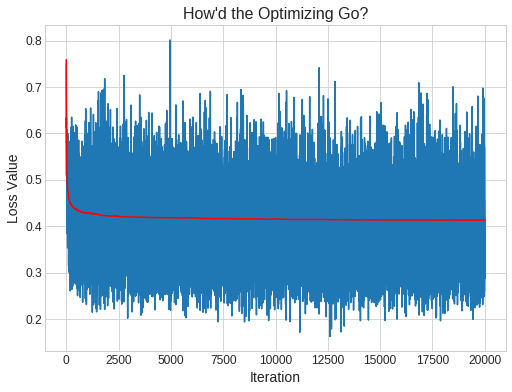

In [29]:
train_neural_net(classifier, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

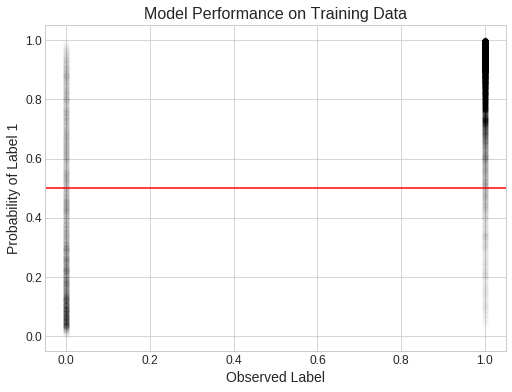

In [30]:
plot_train_perf(predictors_Tensor, outcome_Tensor_binary, classifier, 0.0025, True,
                -0.05, 1.05, 'Observed Label', 'Probability of Label 1', False)

In [31]:
# Get predicted probabilities as binary values
classifier_pred = np.round(classifier(Variable(predictors_Tensor, requires_grad = False)).data.numpy())

# Determine if those predictions are right
number_correct_preds = (classifier_pred == outcome_Tensor_binary.numpy())

# Get the accuracy of those predictions
train_accuracy = (sum(number_correct_preds) / len(number_correct_preds))[0]


# Lets get it in words
'Training set accuracy is: ' + str(train_accuracy)

'Training set accuracy is: 0.828999080191'

In [32]:
cv_classifier_pred = np.round(classifier(Variable(cv_predictors_Tensor, requires_grad = False)).data.numpy())

number_correct_cv_preds = (cv_classifier_pred == cv_outcome_Tensor_binary.numpy())

cv_accuracy = (sum(number_correct_cv_preds) / len(number_correct_cv_preds))[0]


'Cross-validation set accuracy is: ' + str(cv_accuracy)

'Cross-validation set accuracy is: 0.8196639077'

In [33]:
test_classifier_pred = np.round(classifier(Variable(test_predictors_Tensor, requires_grad = False)).data.numpy())

number_correct_test_preds = (test_classifier_pred == test_outcome_Tensor_binary.numpy())

test_accuracy = (sum(number_correct_test_preds) / len(number_correct_test_preds))[0]


'Test set accuracy is: ' + str(test_accuracy)

'Test set accuracy is: 0.825934286431'

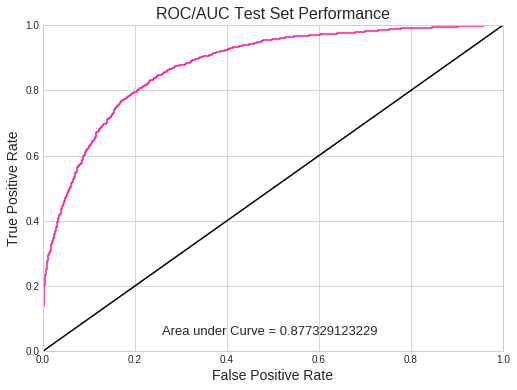

In [34]:
# Get the false positive and true positive rates using scikit-learn
fpr_a, tpr_a, _ = roc_curve(y_true = test_outcome_Tensor_binary.numpy(),
                            y_score = classifier(Variable(test_predictors_Tensor, requires_grad = False)).data.numpy())

# Calculate the area under the curve
area_under = auc(x = fpr_a,
                 y = tpr_a)


# Plot it all
plt.plot(fpr_a, tpr_a, 'deeppink')
plt.plot(fpr_a, fpr_a, 'black')
plt.xlabel('False Positive Rate', size = 14)
plt.ylabel('True Positive Rate', size = 14)
plt.title('ROC/AUC Test Set Performance', size = 16)
plt.text(0.26, 0.05, 'Area under Curve = %s'%(area_under), size = 13)
axes = plt.gca()
axes.set_xlim([0, 1])
axes.set_ylim([0, 1]);

## 3. Get the expected values for 2018

Get the gridded DataFrame of assumed storm characteristics, true geographic values, and potential dates/times

In [35]:
# Import the data to make predictions off of
grid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/final_grid_df.csv")


# Make sure the columns are in the right order
grid_df.columns == test_predictors.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

Importing data to undo model-needed processing

In [36]:
unproc_tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_data_with_interact_effects.csv")

mean_log_dam = np.mean(np.log(unproc_tor_df['DAMAGE_PROPERTY'] + 1))
stand_dev_log_dam = np.std(np.log(unproc_tor_df['DAMAGE_PROPERTY'] + 1))

Get, column-bind, and save the predictions with the grid and cities for the visualizations in R and plot.ly

In [37]:
# Get the expected values for the grid
grid_Tensor = torch.from_numpy(grid_df.values).float()

# Get the damage predictions
grid_damage_predictions = model(Variable(grid_Tensor, requires_grad = False))
grid_damage_predictions = np.exp(((grid_damage_predictions * stand_dev_log_dam) + mean_log_dam).data.numpy())

# Get the probability of damage
grid_classifier_predictions = classifier(Variable(grid_Tensor, requires_grad = False)).data.numpy()

# Compute expected values
grid_expected_values = grid_classifier_predictions * grid_damage_predictions


# Get those predictions into the grid DataFrame and save it
grid_ev_df = pd.DataFrame(grid_expected_values)
grid_ev_df.columns = ['DAMAGE_PROPERTY']
grid_df = pd.concat([grid_ev_df, grid_df], axis = 1)
grid_df.to_csv('grid_with_expectated_values.csv')